# SEO Experiment: Canonical and Mobile Site Tags

Date: June 3, 2020 <br/>
Author: Megan Neisler

[Task](https://phabricator.wikimedia.org/T234807)


# Background

In [T205495](https://phabricator.wikimedia.org/T205495), we added alternate tags for mobile versions of wiki pages on the beta cluster. This was done to help provide Google with the metadata they request in order to properly index mobile sites. In [T206497](https://phabricator.wikimedia.org/T206497) this was enabled on Italian, Dutch, Korean, Arabic, Chinese, and Hindi Wikipedias on October 2, 2019 to determine their effects on traffic from mobile search engines.

This change was implemented based on public recommendations around the requested data for properly indexing the mobile site [https://developers.google.com/search/mobile-sites/mobile-seo/separate-urls] and the analysis done in [T198970](https://phabricator.wikimedia.org/T198970). Google recommends that the relationship between separate urls for desktop and mobile pages be signaled by adding a rel = "alternate" tag pointing to the corresponding mobile URL and a rel = "canonical" tag pointing to the corresponding desktop URL. 

This task is about identifying any impact from this change on search engine-referred traffic on these wikis. If we do not see a negative impact on traffic, we will roll the change out to all sites. 


# Analysis approach

In the analysis, we:
- Reviewed year over year trends in daily traffic from 2016-02-05 (when we began tracking search engine-referred traffic separately from externally-referred traffic in general) through 2019-12-31 (3 months following deployment).

- Reviewed trends in the average search engine-referred page views per day pre and post deployment to both the desktop and mobile test wikis, focusing on external search-related traffic to determine if the change resulted in significant changes. For the analysis, a short-term period (2 weeks before and after the deployment) was reviewed to detemine any changes immediately resulting from the change.

- Compared changes in pre and post deployment traffic to the changes during the same period the previous year to account for seasonality in the data. 

- We also compared trends to the following  group of wikis that were not included in the test. These were also not included in the other SEO experiments (Sitemaps and SameAs).
  - Bhojpuri (bhwiki)
  - Cherokee (chrwiki)
  - Kazakh (kkwiki)
  - Catalan (cawiki)
  - French (frwiki)
  - Yoruba (yowiki)
  - Kalmyk (xalwiki)

-  Reviewed google search console data to determine impression and clicks to mobile and desktop version of the wikis before and after the deployment date.

- Excluded known spider traffic.

- In addition to the aggregated traffic, we also analyzed traffic to the individual languages to see whether any one language dominated or masked the results when combined with others. 

In [191]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [6]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(lubridate); library(ggplot2); library(dplyr); library(RcppRoll)
})

# Google Search Console Data Review

Google search console is recording impressions and clicks for all the test wiki mobile sites, which we would not expect since the addition of the html tags should shift traffic from non-canoncial (alternate) urls to the canonical url. See further info [here](https://webmasters.googleblog.com/2019/02/consolidating-your-website-traffic-on.html).

For example, the chart below shows impressions and clicks for it.m.wikipedia.org and ar.m.wikipedia.org recorded after the tag change was deployed on October 2, 2019. There is no visible change in the data recorded for either site following deployment. Source: Google Search Console Data

## Italian Mobile Wikipedia Google Console Data

<img src="figures/itwiki_mobile_gsc.png">

## Arabic Mobile Wikipedia Google Console Data

<img src="figures/arwiki_mobile_gsc.png">


We further reviewed the implemention of the index tags to ensure they were implemented propertly. It appears that in some cases, Google's system has decided to use the mobile page as the canonical despite explicitly marking the desktop page as the canonical version. As a result, some impressions and clicks to the mobile domain are included in the impression & clicks to the desktop domain when Google has accepted the canonical tag. 

Given the inconsistent handling of tags, it is unlikely we will see any sustained impacts to search-related pageviews due to this change; however, we will review year over year changes to confirm there was no signficant negative impact.


# Data Acquisition

In [ ]:
# In terminal
# spark2R --master yarn --executor-memory 2G --executor-cores 1 --driver-memory 4G

#Query pageviews from both test and non-test wikis form 2016 through 2019

query <-  "
SELECT
  CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) AS date,
  IF(project IN('ar.wikipedia', 'zh.wikipedia', 'hi.wikipedia', 'it.wikipedia', 'nl.wikipedia', 'ko.wikipedia'), 'test', 'non-test') AS test_group,
  project,
  IF(access_method = 'mobile web', 'mobile', 'desktop') AS site_version,
  IF(referer_class = 'external (search engine)', 'search', referer_class) AS referrer,
  SUM(view_count) AS pageviews
FROM wmf.projectview_hourly
WHERE ((year >= 2016 AND month >= 02) OR (year >= 2017 AND year <= 2019))
  AND referer_class IN('none', 'internal', 'external', 'external (search engine)')
  AND agent_type = 'user'
  AND project IN ('ar.wikipedia', 'zh.wikipedia', 'hi.wikipedia', 'it.wikipedia', 'nl.wikipedia', 'ko.wikipedia',
 'bh.wikipedia', 'chr.wikipedia', 'kk.wikipedia','ca.wikipedia', 'fr.wikipedia', 'yo.wikipedia', 'xal.wikipedia')
GROUP BY
  CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')),
  IF(project IN('ar.wikipedia', 'zh.wikipedia', 'hi.wikipedia', 'it.wikipedia', 'nl.wikipedia', 'ko.wikipedia'), 'test', 'non-test'),
  project,
  IF(access_method = 'mobile web', 'mobile', 'desktop'),
  IF(referer_class = 'external (search engine)', 'search', referer_class)
"

results <- collect(sql(query))
save(results, file="data/pageviews.RData")


In [192]:
 load("data/pageviews.RData")
 pageviews <- results

In [193]:
pageviews$date <- as.Date(pageviews$date, format = "%Y-%m-%d")

In [194]:
daily_pageviews <- pageviews %>%  
mutate(period = if_else(date < "2019-10-02", "before", "after"))# change was deployed on October 2nd 2019

# Search-referred pageviews: pre and post deployment analysis

In [201]:
# Review year over year changes in search-related traffic
search_yoy <- daily_pageviews %>%
  filter(date != "2016-02-29",  # filter out leap day
         date <= "2020-01-01", #focus to months right after deploymeny
    referrer == "search") %>%
  group_by(date, site_version, test_group, referrer) %>%
  summarize(pageviews = sum(pageviews)) %>%
  ungroup %>%
  mutate(
    year = factor(year(date)),
    site_version = if_else(site_version == "desktop", "Desktop version", "Mobile (web) version"),
    test_group = if_else(test_group == "non-test", "Wikipedias without mobile alternate tag", "Wikipedias with mobile alternate tag")
  ) %>%
  arrange(site_version, test_group, referrer, date) %>%
  group_by(site_version,test_group, referrer) %>%
  mutate(smoothed = c(rep(NA, 3), RcppRoll::roll_mean(pageviews, 7), rep(NA, 3))) %>%
  ungroup
year(search_yoy$date) <- 2019

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


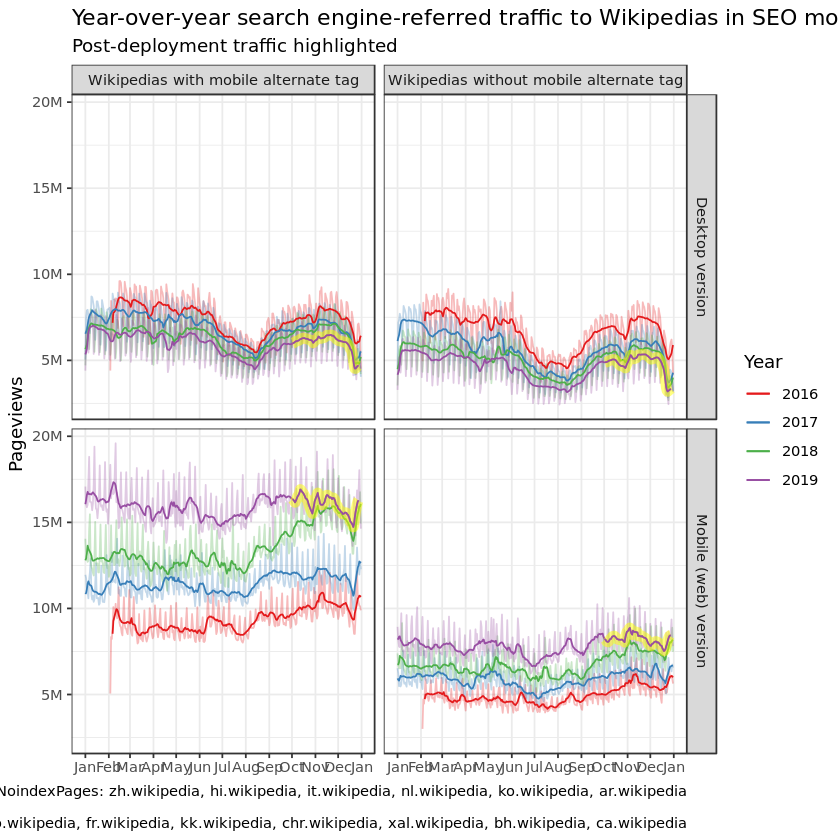

In [202]:
p <- ggplot(search_yoy, aes(x = date, y = smoothed)) +
  geom_line(aes(color = year, y = pageviews), alpha = 0.3) +
  geom_line(aes(color = year)) +
  geom_line(
    data = filter(search_yoy, (year == "2019" & date >= "2019-10-02") | (year == "2020")),
    alpha = 0.5, color = "yellow", size = 3
  ) +
  geom_line(
    aes(color = year),
    data = filter(search_yoy, (year == "2019" & date >= "2019-10-02") | (year == "2020"))
  ) +
  facet_grid(site_version ~ test_group) +
  scale_x_date(date_labels = "%b", date_breaks = "1 month", minor_breaks = NULL) +
  scale_y_continuous(labels = polloi::compress) +
  scale_color_brewer(palette = "Set1") +
  labs(
    x = NULL, y = "Pageviews", color = "Year",
    title = "Year-over-year search engine-referred traffic to Wikipedias in SEO mobile tag test",
    subtitle = "Post-deployment traffic highlighted",
    caption = "Wikipedias with $wgMFNoindexPages: zh.wikipedia, hi.wikipedia, it.wikipedia, nl.wikipedia, ko.wikipedia, ar.wikipedia
      \n Wikipedias without $wgMFNoindexPages: yo.wikipedia, fr.wikipedia, kk.wikipedia, chr.wikipedia, xal.wikipedia, bh.wikipedia, ca.wikipedia"
 ) +
  theme(legend.position = "bottom") + 
  theme_bw()
p

In [203]:
ggsave("figures/search_yoy.png", p, width = 16, height = 8, units = "in", dpi = 300)

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


There was no sudden decline or increase in search-referred traffic immediately following the change. In addition, the traffic changes that follow the deployment of the mobile tags follow the same pattern as previous years and are seen on a set of wikis we reviewed where the change was not deployed, indicating that these changes are likely not attributable to this deployment.

## Year over year changes

To confirm, we reviewed average daily pageviews during two week period (15 days) before and after deployment for this year and compared to the changes that occured over the same period the previous year. 

In [117]:

search_yoy_deployment <- daily_pageviews %>%
    filter(date >= '2018-09-18' & date <= '2018-10-17' 
          | date >= '2019-09-18' & date <= '2019-10-17', #Reviewed period of Sept 19 through Oct 17th. Deployment on Oct 2nd.
          referrer == 'search') %>%
    mutate(year = factor(year(date)),
          period = case_when(date >= '2018-09-18' & date <= '2018-10-02' ~ 'pre',
                            date > '2018-10-02' & date <= '2018-10-17'  ~ 'post',
                            date >= '2019-09-18' & date <= '2019-10-02' ~ 'pre',
                            date > '2019-10-02' & date <= '2019-10-17' ~ 'post')) %>%
    group_by(site_version, year, period, test_group) %>%
    summarise(monthly_views = mean(pageviews)) 

### Desktop Pre and Post Changes in Average Daily Pageview

|      | Test Wikis          | Non-Test Wikis |
|------|---------------------|----------------|
| 2018 | 5.25%               | 3.70%          |
| 2019 | **3.47%**              | **2.75%**        |


### Mobile Pre and Post Changes in Average Daily Pageview

|      | Test Wikis          | Non-Test Wikis |
|------|---------------------|----------------|
| 2018 | 4.54%               | 4.12%          |
| 2019 | **0.03%**               | **-3.56%**         |

Both mobile and desktop daily average search-referred pageviews went up (3.47% on desktop and 0.03% on mobile) following the deployment. This percent increase was only slightly lower than the percent increase seen in 2018 over the same period. In addition, the percent increase in average daily search-referred pageviews around the deployment is slightly higher than the change in traffic observed for the wikis reviewed that were not in the test.  

This indicates there was no negative change due to the mobile tag change during this time.  


## Search-Related Traffic Per Project

We also analyzed traffic to the individual languages to see whether any one language dominated or masked the results when combined with others.

## Itwiki, zhwiki, and nlwiki

In [142]:
# Review year over year changes in search-related traffic grouped by wiki
search_yoy_perwiki_large <- daily_pageviews %>%
  filter(date != "2016-02-29", # filter out leap day
         date <= "2020-01-01", #focus to months right after deployment
    referrer == "search" ,
        test_group == 'test',
        project %in% c('it.wikipedia', 'zh.wikipedia', 'nl.wikipedia')) %>%  #limit to similar size wikis for chart visibility
  group_by(date, project, site_version, referrer) %>%
  summarize(pageviews = sum(pageviews)) %>%
  ungroup %>%
  mutate(
    year = factor(year(date)),
    site_version = if_else(site_version == "desktop", "Desktop version", "Mobile (web) version")
  ) %>%
  arrange(site_version, project, referrer, date) %>%
  group_by(project, site_version, referrer) %>%
  mutate(smoothed = c(rep(NA, 3), RcppRoll::roll_mean(pageviews, 7), rep(NA, 3))) %>%
  ungroup
year(search_yoy_perwiki_large$date) <- 2019

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


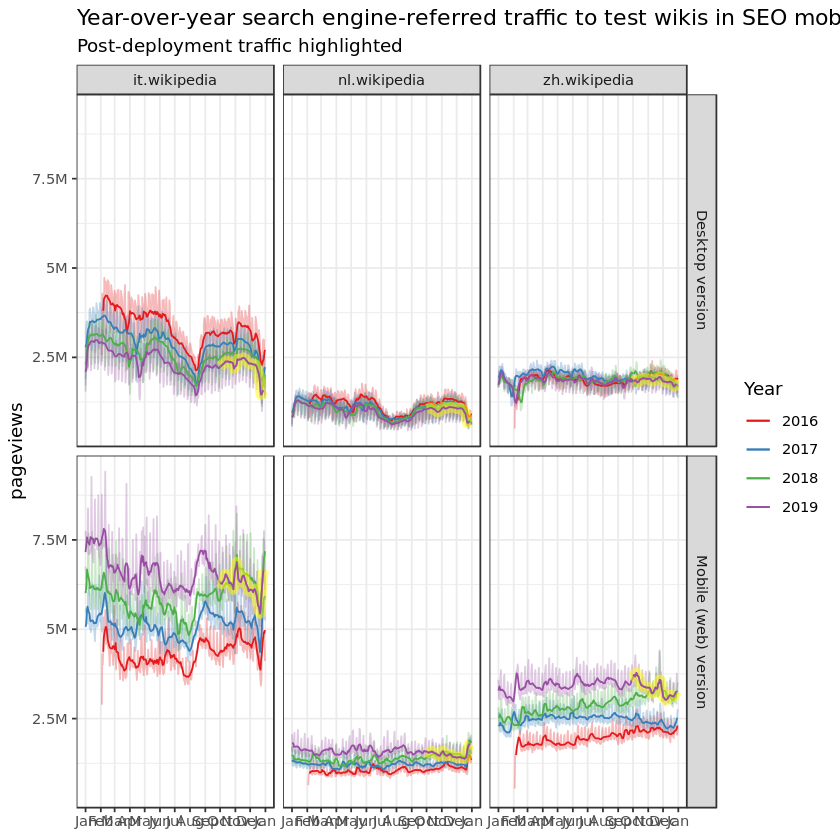

In [207]:
p <- ggplot(search_yoy_perwiki_large, aes(x = date, y = smoothed)) +
  geom_line(aes(color = year, y = pageviews), alpha = 0.3) +
  geom_line(aes(color = year)) +
  geom_line(
    data = filter(search_yoy_perwiki_large, (year == "2019" & date >= "2019-10-02") | (year == "2020")),
    alpha = 0.5, color = "yellow", size = 3
  ) +
  geom_line(
    aes(color = year),
    data = filter(search_yoy_perwiki_large, (year == "2019" & date >= "2019-10-02") | (year == "2020"))
  ) +
  facet_grid(site_version ~ project) +
  scale_x_date(date_labels = "%b", date_breaks = "1 month", minor_breaks = NULL) +
  scale_y_continuous(labels = polloi::compress) +
  scale_color_brewer(palette = "Set1") +
  labs(
    x = NULL, y = "pageviews", color = "Year",
    title = "Year-over-year search engine-referred traffic to test wikis in SEO mobile tag test",
    subtitle = "Post-deployment traffic highlighted"
  ) +
  theme(legend.position = "bottom") + 
  theme_bw()
p

In [208]:
ggsave("figures/search_yoy_perwiki_large.png", p, width = 16, height = 8, units = "in", dpi = 300)

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


In [145]:
# Review year over year changes in search-related traffic grouped by wiki
search_yoy_perwiki_small <- daily_pageviews %>%
  filter(date != "2016-02-29", # filter out leap day
         date <= "2020-01-01", #focus to months right after deployment
    referrer == "search" ,
        test_group == 'test',
        project %in% c('ar.wikipedia', 'hi.wikipedia', 'ko.wikipedia')) %>%  #limit to similar size wikis for chart visibility
  group_by(date, project, site_version, referrer) %>%
  summarize(pageviews = sum(pageviews)) %>%
  ungroup %>%
  mutate(
    year = factor(year(date)),
    site_version = if_else(site_version == "desktop", "Desktop version", "Mobile (web) version")
  ) %>%
  arrange(site_version, project, referrer, date) %>%
  group_by(project, site_version, referrer) %>%
  mutate(smoothed = c(rep(NA, 3), RcppRoll::roll_mean(pageviews, 7), rep(NA, 3))) %>%
  ungroup
year(search_yoy_perwiki_small$date) <- 2019

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


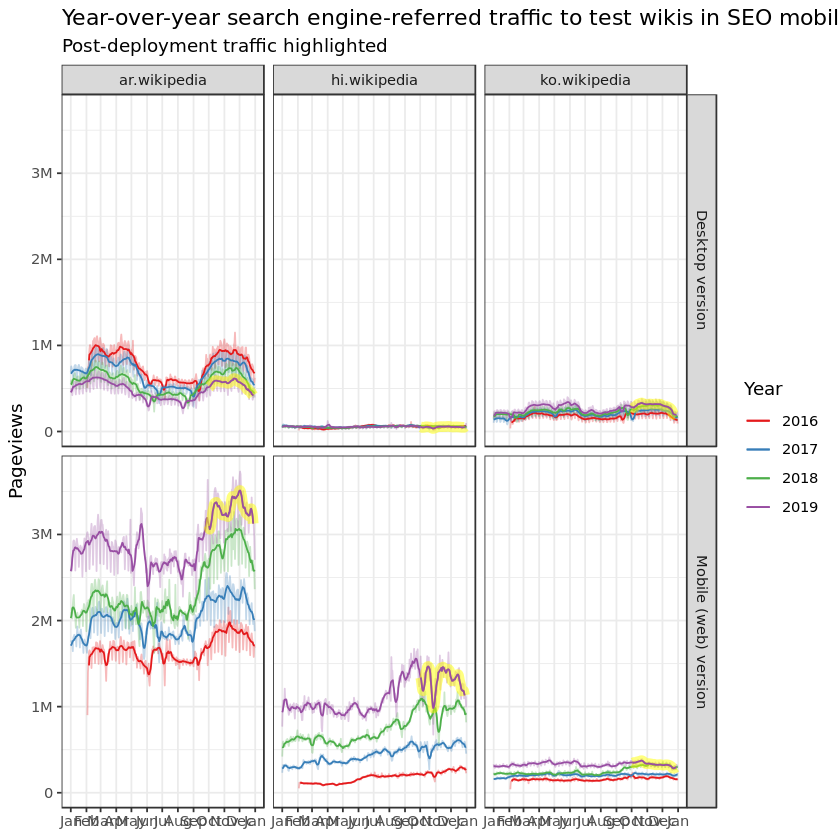

In [210]:
p <- ggplot(search_yoy_perwiki_small, aes(x = date, y = smoothed)) +
  geom_line(aes(color = year, y = pageviews), alpha = 0.3) +
  geom_line(aes(color = year)) +
  geom_line(
    data = filter(search_yoy_perwiki_small, (year == "2019" & date >= "2019-10-02") | (year == "2020")),
    alpha = 0.5, color = "yellow", size = 3
  ) +
  geom_line(
    aes(color = year),
    data = filter(search_yoy_perwiki_small, (year == "2019" & date >= "2019-10-02") | (year == "2020"))
  ) +
  facet_grid(site_version ~ project) +
  scale_x_date(date_labels = "%b", date_breaks = "1 month", minor_breaks = NULL) +
  scale_y_continuous(labels = polloi::compress) +
  scale_color_brewer(palette = "Set1") +
  labs(
    x = NULL, y = "Pageviews", color = "Year",
    title = "Year-over-year search engine-referred traffic to test wikis in SEO mobile tag test",
    subtitle = "Post-deployment traffic highlighted"
  ) +
  theme(legend.position = "bottom")  + 
  theme_bw()
p

In [211]:
ggsave("figures/search_yoy_perwiki_small.png", p, width = 16, height = 8, units = "in", dpi = 300)

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


## Individual wiki year over year changes

In [126]:
search_yoy_deployment_perwiki <- daily_pageviews %>%
    filter(test_group == 'test',
           referrer == "search" ,
           (date >= '2018-09-18' & date <= '2018-10-17' 
          | date >= '2019-09-18' & date <= '2019-10-17')) %>%
    mutate(year = factor(year(date)),
          period = case_when(date >= '2018-09-18' & date <= '2018-10-02' ~ 'pre',
                            date > '2018-10-02' & date <= '2018-10-17'  ~ 'post',
                            date >= '2019-09-18' & date <= '2019-10-02' ~ 'pre',
                            date > '2019-10-02' & date <= '2019-10-17' ~ 'post')) %>%
    group_by(site_version, year, period, test_group, project) %>%
    summarise(monthly_views = mean(pageviews)) 


### Average Daily Pageviews Pre and Post Deployment

Desktop


|        | 2018 | 2019 |
|--------|------|------|
| arwiki |18.05% | 14.86%  |
| zhwiki |   2.84%  | 0.08%  |
| hiwiki |  -0.20%    | -16.50%   |
| itwiki | 4.61%  |  4.39%   |
| nlwiki |  2.37%   |  4.36%   |
| kowiki |  16.34%   |  -0.07%    |




Mobile


|        | 2018 | 2019 |
|--------|------|------|
| arwiki |  6.33%  |  4.71%  |
| zhwiki |  5.67% | 3.75%  |
| hiwiki |   1.23%  |  -12.48%   |
| itwiki |  3.41%  |  -1.31%    |
| nlwiki | 5.81%   |  -0.50%   |
| kowiki |   5.73%   | 1.97%    |


There is no sudden increase or decrease observed for any of the test wikis immediately following the deployment, with the exception of hiwiki. There was a pre and post deployment drop observed in hiwiki for both desktop (-16.50%) and mobile (-12.48%). 

I reviewed overall pageviews pre and post deployment for hi.wikipedia to confirm if this drop was isolated to search-referred traffic.



### Overall Pageviews for hi.wikipeda broken down by referrer

In [151]:
head(daily_pageviews)

,date,test_group,project,site_version,referrer,pageviews,period
,<date>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,2020-04-27,non-test,yo.wikipedia,mobile,search,199,after
2,2020-04-27,test,zh.wikipedia,desktop,external,61702,after
3,2017-10-03,test,hi.wikipedia,desktop,none,31341,before
4,2019-01-08,non-test,fr.wikipedia,desktop,internal,3901912,before
5,2017-10-12,test,zh.wikipedia,desktop,external,73340,before
6,2019-09-23,non-test,fr.wikipedia,mobile,external,129899,before


In [212]:
# Review year over year changes in overall traffic - not limited to search-driven traffic
pageview_yoy_hiwiki <- daily_pageviews %>%
  filter(date >= "2019-01-01", # isolate to year of deployment
         date <= "2020-01-01",
        project == 'hi.wikipedia',
        ) %>%  
  group_by(date, site_version, referrer) %>%
  summarize(pageviews = sum(pageviews)) %>%
  ungroup %>%
  mutate(
    year = factor(year(date)),
    site_version = if_else(site_version == "desktop", "Desktop version", "Mobile (web) version")
  ) %>%
  arrange(site_version, referrer, date) %>%
  group_by(site_version, referrer) %>%
  mutate(smoothed = c(rep(NA, 3), RcppRoll::roll_mean(pageviews, 7), rep(NA, 3))) %>%
  ungroup

Warning message:
“Removed 24 row(s) containing missing values (geom_path).”


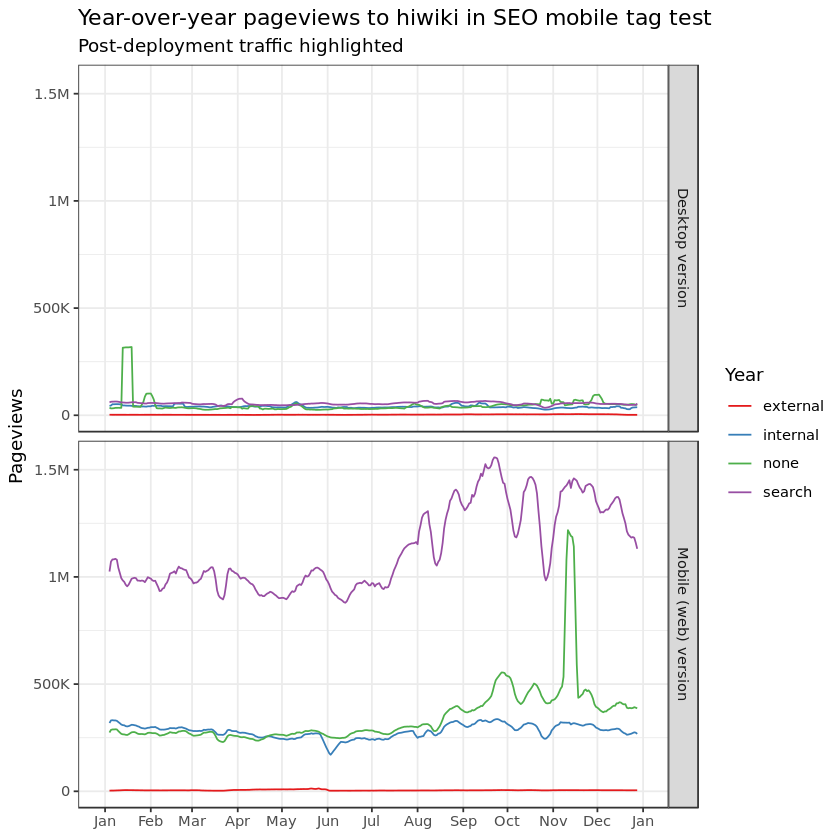

In [213]:
p <- ggplot(pageview_yoy_hiwiki, aes(x = date, y = smoothed, color = referrer)) +
  geom_line() +
  facet_grid(site_version ~ .) +
  scale_x_date(date_labels = "%b", date_breaks = "1 month", minor_breaks = NULL) +
  scale_y_continuous(labels = polloi::compress) +
  scale_color_brewer(palette = "Set1") +
  labs(
    x = NULL, y = "Pageviews", color = "Year",
    title = "Year-over-year pageviews to hiwiki in SEO mobile tag test",
    subtitle = "Post-deployment traffic highlighted"
  ) +
  theme(legend.position = "bottom") + 
  theme_bw()
            
p

There was also a slight dip in all the other referrers at this time on hi.m.wikipedia and they all occur around October 6th. This decrease occurs several days after the deployment date and is not sustained. 

# Overall pageviews by referrer

Next, we will review the trend in overall pageviews broken down by referrer during this time to confirm the traffic trends during this time across all referrer types. 

In [181]:
pageview_yoy_byreferrer <- daily_pageviews %>%
  filter(date >= "2019-01-01", # isolate to year of deployment
         date <= "2020-01-01",
         test_group == 'test', #review only test wikis
         referrer != 'external' #remove-there's very few external referrer not categorized as search
        ) %>%  
  group_by(date, site_version, referrer) %>%
  summarize(pageviews = sum(pageviews)) %>%
  ungroup %>%
  mutate(
    year = factor(year(date)),
    site_version = if_else(site_version == "desktop", "Desktop version", "Mobile (web) version")
  ) %>%
  arrange(site_version, referrer, date) %>%
  group_by(site_version, referrer) %>%
  mutate(smoothed = c(rep(NA, 3), RcppRoll::roll_mean(pageviews, 7), rep(NA, 3))) %>%
  ungroup

Warning message:
“Removed 18 row(s) containing missing values (geom_path).”


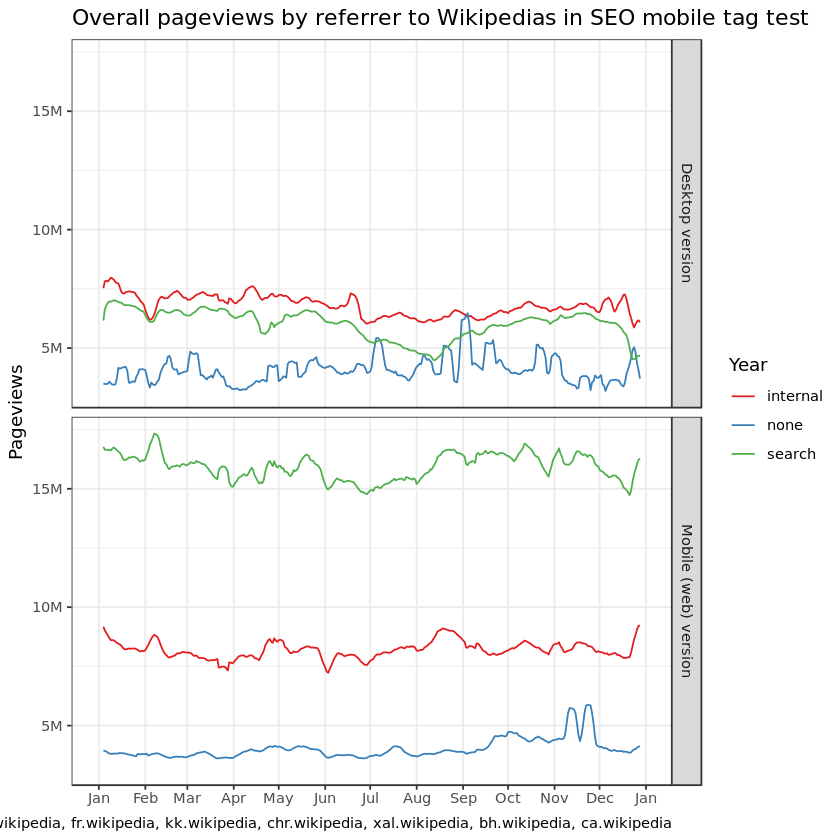

In [215]:
p <- ggplot(pageview_yoy_byreferrer, aes(x = date, y = smoothed, color = referrer)) +
  geom_line() +
  facet_grid(site_version ~ .) +
  scale_x_date(date_labels = "%b", date_breaks = "1 month", minor_breaks = NULL) +
  scale_y_continuous(labels = polloi::compress) +
  scale_color_brewer(palette = "Set1") +
  labs(
    x = NULL, y = "Pageviews", color = "Year",
    title = "Overall pageviews by referrer to Wikipedias in SEO mobile tag test",
    caption = paste("Wikipedias with Mobile site Index Change:", wiki_groups)
  ) +
  theme(legend.position = "bottom")+ 
  theme_bw()
            
p

In [216]:
ggsave("figures/pageview_yoy_byreferrer.png", p, width = 16, height = 8, units = "in", dpi = 300)

Warning message:
“Removed 18 row(s) containing missing values (geom_path).”


A review of overall pageviews broken out by referrer shows slight bumps in overall pageviews in early October 2019 for both external search referrers and interal searches on mobile.

# Overall pageviews year over year changes

In [218]:
# Review year over year changes in overall traffic - not limited to search-driven traffic
pageview_yoy <- daily_pageviews %>%
  filter(date != "2016-02-29", # filter out leap day
         date <= "2020-01-01") %>%  #focus to months right after deployment 
  group_by(date, site_version, test_group) %>%
  summarize(pageviews = sum(pageviews)) %>%
  ungroup %>%
  mutate(
    year = factor(year(date)),
    site_version = if_else(site_version == "desktop", "Desktop version", "Mobile (web) version"),
    test_group = if_else(test_group == "non-test", "Wikipedias without mobile alternate tag", "Wikipedias with mobile alternate tag")
  ) %>%
  arrange(site_version, test_group, date) %>%
  group_by(site_version, test_group) %>%
  mutate(smoothed = c(rep(NA, 3), RcppRoll::roll_mean(pageviews, 7), rep(NA, 3))) %>%
  ungroup
year(pageview_yoy$date) <- 2019

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


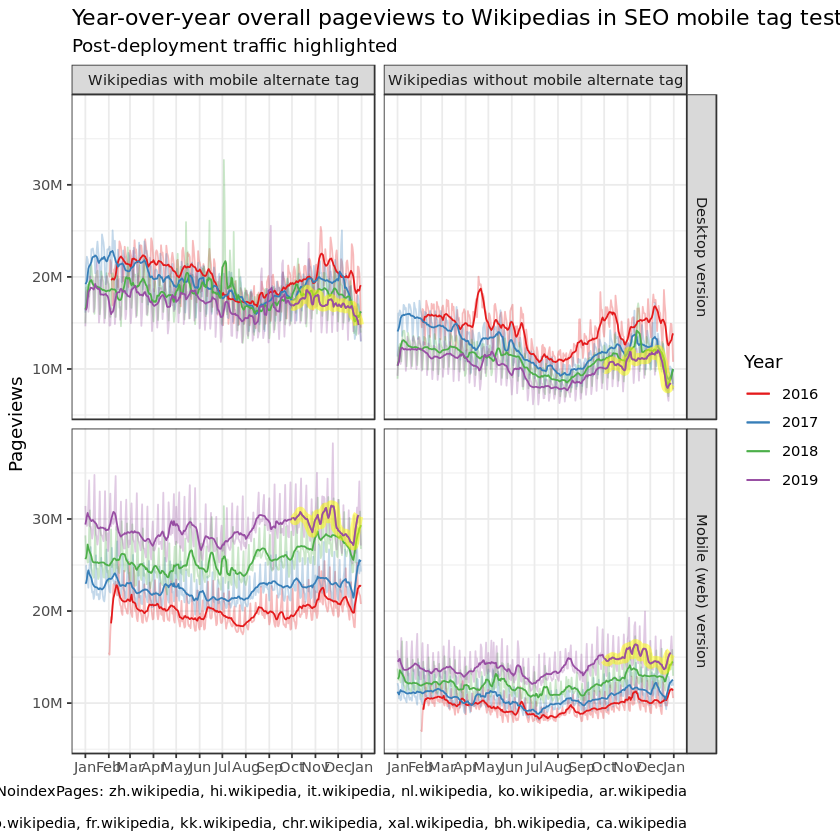

In [219]:
p <- ggplot(pageview_yoy, aes(x = date, y = smoothed)) +
  geom_line(aes(color = year, y = pageviews), alpha = 0.3) +
  geom_line(aes(color = year)) +
  geom_line(
    data = filter(pageview_yoy, (year == "2019" & date >= "2019-10-02") | (year == "2020")),
    alpha = 0.5, color = "yellow", size = 3
  ) +
  geom_line(
    aes(color = year),
    data = filter(pageview_yoy, (year == "2019" & date >= "2019-10-02") | (year == "2020"))
  ) +
  facet_grid(site_version ~ test_group) +
  scale_x_date(date_labels = "%b", date_breaks = "1 month", minor_breaks = NULL) +
  scale_y_continuous(labels = polloi::compress) +
  scale_color_brewer(palette = "Set1") +
  labs(
    x = NULL, y = "Pageviews", color = "Year",
    title = "Year-over-year overall pageviews to Wikipedias in SEO mobile tag test",
    subtitle = "Post-deployment traffic highlighted",
     caption = "Wikipedias with $wgMFNoindexPages: zh.wikipedia, hi.wikipedia, it.wikipedia, nl.wikipedia, ko.wikipedia, ar.wikipedia
      \n Wikipedias without $wgMFNoindexPages: yo.wikipedia, fr.wikipedia, kk.wikipedia, chr.wikipedia, xal.wikipedia, bh.wikipedia, ca.wikipedia"
  ) +
  theme(legend.position = "bottom")+ 
  theme_bw()
p

In [220]:
ggsave("figures/pageview_yoy.png", p, width = 16, height = 8, units = "in", dpi = 300)

Warning message:
“Removed 6 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


In [107]:
# review pageviews during two week period -15 days- before and after deployment for this year  
# compare to previous year change over the same period.

pageview_yoy_deployment <- daily_pageviews %>%
    filter(date >= '2018-09-18' & date <= '2018-10-17' 
          | date >= '2019-09-18' & date <= '2019-10-17') %>%
    mutate(year = factor(year(date)),
          period = case_when(date >= '2018-09-18' & date <= '2018-10-02' ~ 'pre',
                            date > '2018-10-02' & date <= '2018-10-17'  ~ 'post',
                            date >= '2019-09-18' & date <= '2019-10-02' ~ 'pre',
                            date > '2019-10-02' & date <= '2019-10-17' ~ 'post')) %>%
     group_by(site_version, year, period, test_group) %>%
    summarise(monthly_views = mean(pageviews)) 

Overall average daily pageviews decreased only slightly on desktop (-1.34%) and increased slightly (1.14%) on mobile following deployment of the change. 


# Summary

Based on these results, there appears to be no signficant negative impact on search-referred traffic to the test wikis. There were no visible changes in traffic to either the desktop or mobile versions of the site that could be clearly attributed to the deployment of this change.

Since this was not a randomized controlled experiment, we were not able to detect a causal impact with this test. However, results provide no reason to suspect a negative effect so a full statisical analysis is not needed. 